In [1]:
import sys 
sys.path.append('../scripts/')
from mcl import *
from matplotlib.patches import Ellipse

In [2]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0)
        self.cov = np.array([[1e100,0], [0,1e100]])
        
    def draw(self, ax, elems):        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        eig_vals, eig_vec = np.linalg.eig(self.cov)
        ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
        e = Ellipse(self.pos, width=3*eig_vals[0],height=3*eig_vals[1], angle=ang, fill=False, color="blue", alpha=0.5)
        elems.append(ax.add_patch(e))

In [3]:
class FastSlamParticle(Particle): 
    def __init__(self, weight):
        super().__init__(np.array([0,0,0]).T, weight)

In [4]:
class FastSlam(Mcl):
    def __init__(self, num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, None, num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [FastSlamParticle(1.0/num) for i in range(num)] #super().__init__で作ったパーティクルの集合を破棄して再作成
        
    def observation_update(self, observation): 
        pass

In [5]:
class FastSlamAgent(EstimationAgent): 
    def __init__(self, time_interval, nu, omega, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(time_interval, nu, omega, None, None, particle_num, motion_noise_stds)
        
        self.mcl = FastSlam(particle_num, motion_noise_stds) #super().__init__で作ったMclのオブジェクトを破棄してFastSlamのものを作成

<IPython.core.display.Javascript object>


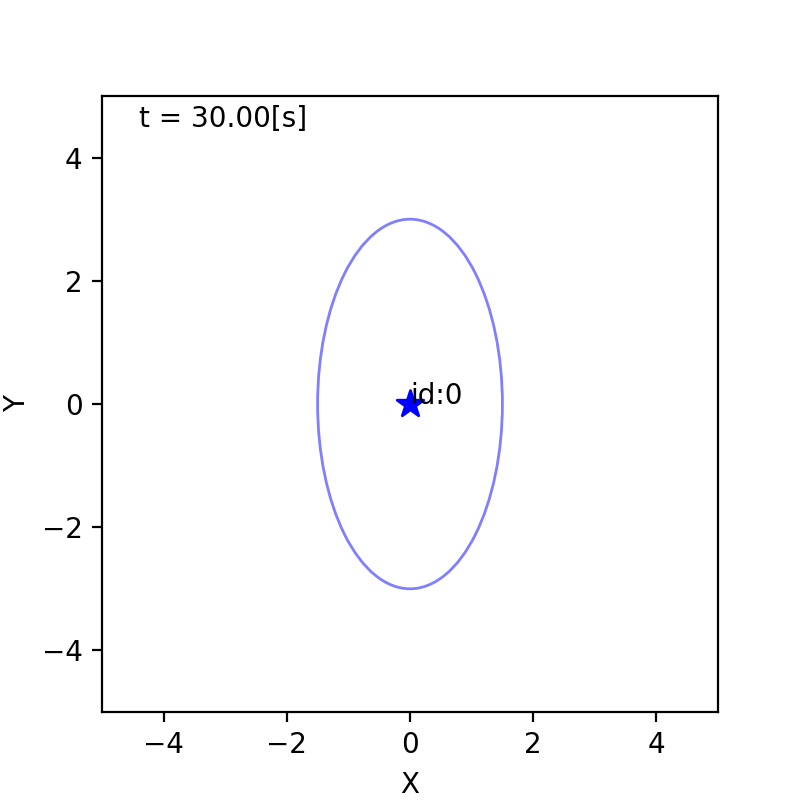

In [6]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    m = Map()
    m.append_landmark(EstimatedLandmark())
    m.landmarks[0].cov = np.array([[1,0], [0,2]])
    world.append(m)

    world.draw()

<IPython.core.display.Javascript object>


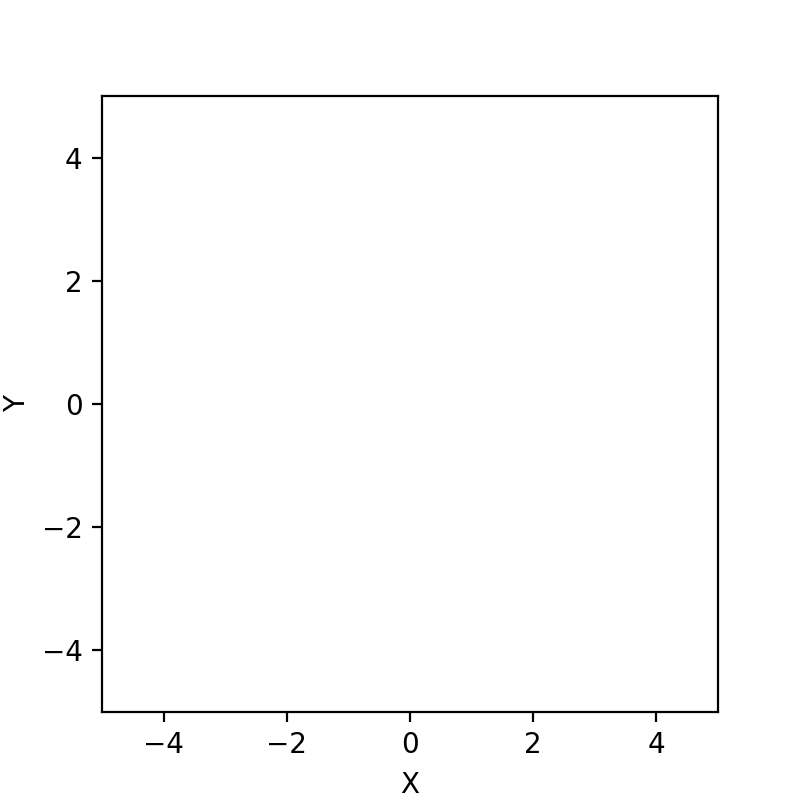

In [7]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    a = FastSlamAgent(time_interval, 0.2, 10.0/180*math.pi, particle_num=100)
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
    #r.one_step(time_interval)  # アニメーションなしでデバッグするとき